In [56]:
import numpy as np
import umap
import matplotlib.pyplot as plt
import pandas as pd
import json
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import gensim
import gensim.corpora as corpora
import re
import numpy as np
from pprint import pprint
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt

<h1> Reading in the Data </h1>

In [57]:
filename = "ml-arxiv-embeddings.json"

items = []
max_items = 100000
count = 0

with open(filename, 'r') as file:
    for line in file:
        try:
            item = json.loads(line)
            items.append(item)
            count += 1
            if count >= max_items:
                break
        except json.JSONDecodeError:
            pass

In [58]:
#Removing symbols from Abstracts
df['abstract_cleaned'] = df.apply(lambda row: (re.sub("[^A-Za-z0-9' ]+", ' ', row['abstract'])),axis=1)

In [59]:
df['abstract_cleaned']

0          Traditionally  semantics has been seen as a ...
1          Structured sparse coding and the related str...
2          In this paper  the continuity and strong con...
3          We study the complexity of reasoning in abst...
4          Scikit learn is a Python module integrating ...
                               ...                        
99995      Robotic Process Automation  RPA  is a fast e...
99996      Reinforcement learning  RL  combines a contr...
99997      Multi tasking optimization can usually achie...
99998      Delivering useful hydrological forecasts is ...
99999      The initial remarks in this technical report...
Name: abstract_cleaned, Length: 100000, dtype: object

In [60]:
# Assuming df is your DataFrame and 'abstract_cleaned' contains strings of text
stop_words = set(stopwords.words('english'))

# Function to remove stopwords from a string
def remove_stopwords(text):
    words = text.split()  # Splitting the string into words
    filtered_words = [word for word in words if word not in stop_words]
    return ' '.join(filtered_words)  # Joining words back into a string

# Applying the function to each row in the DataFrame
df['abstract_cleaned'] = df['abstract_cleaned'].apply(remove_stopwords)

In [61]:
df['abstract_cleaned']

0        Traditionally semantics seen feature human lan...
1        Structured sparse coding related structured di...
2        In paper continuity strong continuity domain f...
3        We study complexity reasoning abstracts argume...
4        Scikit learn Python module integrating wide ra...
                               ...                        
99995    Robotic Process Automation RPA fast emerging a...
99996    Reinforcement learning RL combines control pro...
99997    Multi tasking optimization usually achieve bet...
99998    Delivering useful hydrological forecasts criti...
99999    The initial remarks technical report primarily...
Name: abstract_cleaned, Length: 100000, dtype: object

In [65]:
# Tokenize and lemmatize each row in the 'abstract_cleaned' column
df['abstract_cleaned'] = df['abstract_cleaned'].apply(lambda x: [lemmatizer.lemmatize(w) for w in word_tokenize(x)])

In [68]:
df['abstract_cleaned'][0][:10]

['Traditionally',
 'semantics',
 'seen',
 'feature',
 'human',
 'language',
 'The',
 'advent',
 'information',
 'era']

<h1> Building LDA Topic Model </h1>

In [69]:
# Creating Dictionary and Corpus
dictionary = corpora.Dictionary(df['abstract_cleaned'])
texts = df['abstract_cleaned']
corpus = [dictionary.doc2bow(text) for text in df['abstract_cleaned']]

In [70]:
# Building LDA Model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [71]:
top_topics = []

for doc in corpus:
    # Get the list of topic probabilities
    doc_topics = lda_model.get_document_topics(doc, minimum_probability=0.0)
    # Sort the topics by probability
    doc_topics = sorted(doc_topics, key=lambda x: x[1], reverse=True)
    # Get the highest probability topic
    top_topic = doc_topics[0][0] if doc_topics else None
    top_topics.append(top_topic)

# Add the top topics to your DataFrame
df['top_topic'] = top_topics

In [73]:
def format_topics(topics, num_topics=5):
    # Sort topics by their probabilities
    sorted_topics = sorted(topics, key=lambda x: x[1], reverse=True)
    # Select the top 'num_topics' topics
    top_topics = sorted_topics[:num_topics]
    # Format them as a string or a dictionary
    return ", ".join([f"Topic {topic[0]}: {topic[1]:.2f}" for topic in top_topics])

# List to store the top topics for each document
top_topics_list = []

for doc in corpus:
    # Get the topic distribution for the document
    doc_topics = lda_model.get_document_topics(doc)
    # Format the top 5 topics
    top_topics_str = format_topics(doc_topics, num_topics=5)
    # Append to the list
    top_topics_list.append(top_topics_str)

# Add the top topics to your DataFrame
df['top_5_topics'] = top_topics_list

In [75]:
# Number of words to represent each topic
num_words = 5

# Create a dictionary to map topic numbers to top words
topic_words = {}
for topic_id in range(lda_model.num_topics):
    # Get top words for the topic
    words = lda_model.show_topic(topic_id, topn=num_words)
    topic_words[topic_id] = ", ".join([word for word, _ in words])

# Function to format the top topics with words
def format_topics_with_words(topics, num_topics=5):
    sorted_topics = sorted(topics, key=lambda x: x[1], reverse=True)
    top_topics = sorted_topics[:num_topics]
    return ", ".join([f"{topic_words[topic[0]]}: {topic[1]:.2f}" for topic in top_topics])

# List to store the top topics with words for each document
top_topics_list = []

for doc in corpus:
    doc_topics = lda_model.get_document_topics(doc)
    top_topics_str = format_topics_with_words(doc_topics, num_topics=5)
    top_topics_list.append(top_topics_str)

# Add the top topics with words to your DataFrame
df['top_5_topics_with_words'] = top_topics_list


In [77]:
df_2 = df.drop(columns=['Abstract_Cleaned', 'abstract_cleaned_2'])

In [79]:
df_2.iloc[0]

id                                                                 1201.0328
submitter                                                    Emanuel Diamant
authors                                                      Emanuel Diamant
title                      Let us first agree on what the term "semantics...
comments                                                                None
journal-ref                                                             None
doi                                                                     None
report-no                                                               None
categories                                                    cs.AI q-bio.NC
license                    http://arxiv.org/licenses/nonexclusive-distrib...
abstract                     Traditionally, semantics has been seen as a ...
versions                   [{'version': 'v1', 'created': 'Sun, 1 Jan 2012...
update_date                                                       2012-01-05

In [80]:
df_2.to_csv('data_100000.csv')

In [19]:
import umap
from sklearn.preprocessing import LabelEncoder

embeddings = df['embedding']

In [20]:
# Initialize UMAP

embeddings_list = embeddings.tolist()  # Convert to list of lists
embeddings_array = np.array(embeddings_list)  # Convert to NumPy array

reducer = umap.UMAP()

# Fit and transform the embeddings
embedding_2d = reducer.fit_transform(embeddings_array)


In [24]:
df

,id,submitter,authors,title,comments,journal-ref,doi,report-no,categories,license,abstract,versions,update_date,authors_parsed,embedding,categories-first
0,1201.0328,Emanuel Diamant,Emanuel Diamant,"Let us first agree on what the term ""semantics...",None,None,None,None,cs.AI q-bio.NC,http://arxiv.org/licenses/nonexclusive-distrib...,"Traditionally, semantics has been seen as a ...","[{'version': 'v1', 'created': 'Sun, 1 Jan 2012...",2012-01-05,"[[Diamant, Emanuel, ]]","[-0.0017840689979493618, 0.00692696264013648, ...",cs.AI
1,1201.0341,Zoltan Szabo,"Zoltan Szabo, Barnabas Poczos, Andras Lorincz",Collaborative Filtering via Group-Structured D...,A compressed version of the paper has been acc...,International Conference on Latent Variable An...,10.1007/978-3-642-28551-6_31,None,math.OC cs.LG math.ST stat.ML stat.TH,http://arxiv.org/licenses/nonexclusive-distrib...,Structured sparse coding and the related str...,"[{'version': 'v1', 'created': 'Sun, 1 Jan 2012...",2012-03-08,"[[Szabo, Zoltan, ], [Poczos, Barnabas, ], [Lor...","[-0.0310051292181015, 0.025293657556176186, 0....",math.OC
2,1201.0414,Xuechong Guan,Xuechong Guan and Yongming Li,Continuity in Information Algebras,None,None,10.1142/S0218488512500304,None,cs.AI,http://creativecommons.org/licenses/by-nc-sa/3.0/,"In this paper, the continuity and strong con...","[{'version': 'v1', 'created': 'Mon, 2 Jan 2012...",2012-10-08,"[[Guan, Xuechong, ], [Li, Yongming, ]]","[0.004874754697084427, 0.012842132709920406, 0...",cs.AI
3,1201.0478,Wolfgang Dvo\v{r}\'ak,Wolfgang Dvo\v{r}\'ak,Technical Note: Exploring \Sigma^P_2 / \Pi^P_2...,None,None,None,None,cs.AI cs.CC,http://arxiv.org/licenses/nonexclusive-distrib...,We study the complexity of reasoning in abst...,"[{'version': 'v1', 'created': 'Mon, 2 Jan 2012...",2015-03-19,"[[Dvořák, Wolfgang, ]]","[0.022391721606254578, 0.0009396650712005794, ...",cs.AI
4,1201.0490,Fabian Pedregosa,"Fabian Pedregosa, Ga\""el Varoquaux, Alexandre ...",Scikit-learn: Machine Learning in Python,Update authors list and URLs,Journal of Machine Learning Research (2011),None,None,cs.LG cs.MS,http://arxiv.org/licenses/nonexclusive-distrib...,Scikit-learn is a Python module integrating ...,"[{'version': 'v1', 'created': 'Mon, 2 Jan 2012...",2018-06-06,"[[Pedregosa, Fabian, ], [Varoquaux, Gaël, ], [...","[-0.005777249112725258, 0.004434410948306322, ...",cs.LG
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1205.5742,Ashraf Qadir,"Ashraf Qadir, William Semke, and Jeremiah Neubert",Implementation of an Onboard Visual Tracking S...,9 pages; 6 figures; International Journal of I...,None,None,None,cs.RO,http://arxiv.org/licenses/nonexclusive-distrib...,This paper presents a visual tracking system...,"[{'version': 'v1', 'created': 'Fri, 25 May 201...",2012-05-28,"[[Qadir, Ashraf, ], [Semke, William, ], [Neube...","[-0.024557508528232574, -0.003038007766008377,...",cs.RO
996,1205.5819,Damjan Kalajdzievski,Damjan Kalajdzievski,Measurability Aspects of the Compactness Theor...,"Latex 2e, 64 pages, 1 figure. This is an M.Sc....",None,None,None,stat.ML cs.LG,http://arxiv.org/licenses/nonexclusive-distrib...,It was proved in 1998 by Ben-David and Litma...,"[{'version': 'v1', 'created': 'Fri, 25 May 201...",2015-03-20,"[[Kalajdzievski, Damjan, ]]","[0.00807343702763319, 0.010224091820418835, 0....",stat.ML
997,1205.5823,Hector Zenil,Roger Penrose,"Foreword: A Computable Universe, Understanding...","26 pages, foreword to the book A Computable Un...",None,None,None,cs.GL cs.AI cs.CC cs.IT math.IT physics.hist-p...,http://arxiv.org/licenses/nonexclusive-distrib...,I am most honoured to have the privilege to ...,"[{'version': 'v1', 'created': 'Fri, 25 May 201...",2012-05-29,"[[Penrose, Roger, ]]","[0.016407644376158714, -0.007743921596556902, ...",cs.GL
998,1205.5866,G K Panda,"B. K. Tripathy, G. K. Panda",Approximate Equalities on Rough Intuitionistic...,None,IJCSI International Journal of Computer Scienc...,None,None,cs.AI,http://arxiv.org/licenses

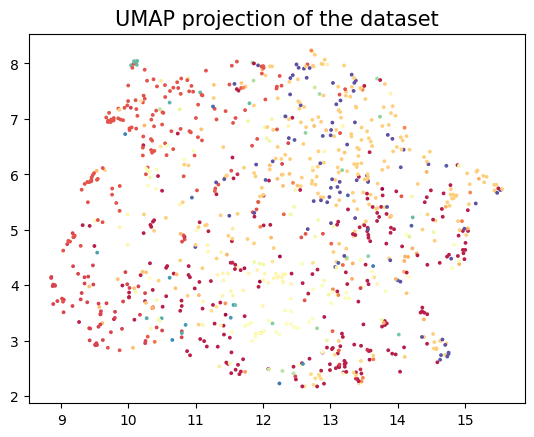

In [23]:
# Convert categories to numeric values
le = LabelEncoder()
categories_numeric = le.fit_transform(df['categories-first'])


# Plotting
plt.scatter(embedding_2d[:, 0], embedding_2d[:, 1], c=categories_numeric, s=3, cmap='Spectral')
plt.title('UMAP projection of the dataset', fontsize=15)
plt.show()

In [85]:
df_2.tail()

,id,submitter,authors,title,comments,journal-ref,doi,report-no,categories,license,abstract,versions,update_date,authors_parsed,embedding,categories-first,abstract_cleaned,top_topic,top_5_topics,top_5_topics_with_words
99995,2001.00804,Simone Agostinelli,"Simone Agostinelli, Andrea Marrella and Massim...",Towards Intelligent Robotic Process Automation...,None,None,None,None,cs.AI cs.SE,http://arxiv.org/licenses/nonexclusive-distrib...,Robotic Process Automation (RPA) is a fast-e...,"[{'version': 'v1', 'created': 'Fri, 3 Jan 2020...",2020-01-06,"[[Agostinelli, Simone, ], [Marrella, Andrea, ]...","[-0.02255321480333805, -0.007440934423357248, ...",cs.AI,"[Robotic, Process, Automation, RPA, fast, emer...",0,"Topic 0: 0.32, Topic 5: 0.27, Topic 6: 0.14, T...","method, data, In, The, based: 0.32, object, hu..."
99996,2001.00805,Brendan O'Donoghue,"Brendan O'Donoghue, Ian Osband, Catalin Ionescu",Making Sense of Reinforcement Learning and Pro...,ICLR 2020,None,None,None,cs.LG cs.AI,http://arxiv.org/licenses/nonexclusive-distrib...,Reinforcement learning (RL) combines a contr...,"[{'version': 'v1', 'created': 'Fri, 3 Jan 2020...",2020-11-05,"[[O'Donoghue, Brendan, ], [Osband, Ian, ], [Io...","[-0.011015553027391434, 0.007968557067215443, ...",cs.LG,"[Reinforcement, learning, RL, combine, control...",0,"Topic 0: 0.31, Topic 9: 0.28, Topic 6: 0.19, T...","method, data, In, The, based: 0.31, algorithm,..."
99997,2001.00810,Zhengping Liang,"Zhengping Liang, Weiqi Liang, Xiuju Xu, Ling L...",A Two stage Adaptive Knowledge Transfer Evolut...,"14 pages, 8 figures, 7 tables, 61 references",None,10.1109/TSMC.2021.3096220,None,cs.NE,http://arxiv.org/licenses/nonexclusive-distrib...,Multi-tasking optimization can usually achie...,"[{'version': 'v1', 'created': 'Fri, 3 Jan 2020...",2021-08-03,"[[Liang, Zhengping, ], [Liang, Weiqi, ], [Xu, ...","[-0.0165249090641737, -0.018765809014439583, 0...",cs.NE,"[Multi, tasking, optimization, usually, achiev...",0,"Topic 0: 0.43, Topic 9: 0.23, Topic 6: 0.10, T...","method, data, In, The, based: 0.43, algorithm,..."
99998,2001.00811,Georgia Papacharalampous,"Georgia Papacharalampous, Hristos Tyralis",Hydrological time series forecasting using sim...,None,Journal of Hydrology 590 (2020) 125205,10.1016/j.jhydrol.2020.125205,None,stat.AP cs.LG stat.ME stat.ML,http://creativecommons.org/licenses/by/4.0/,Delivering useful hydrological forecasts is ...,"[{'version': 'v1', 'created': 'Thu, 2 Jan 2020...",2020-08-19,"[[Papacharalampous, Georgia, ], [Tyralis, Hris...","[-0.00544024258852005, 0.01029845792800188, -0...",stat.AP,"[Delivering, useful, hydrological, forecast, c...",0,"Topic 0: 0.48, Topic 5: 0.12, Topic 6: 0.12, T...","method, data, In, The, based: 0.48, object, hu..."
99999,2001.00813,Ian Barrodale,Ian Barrodale,Computing L1 Straight-Line Fits to Data (Part 1),The report is 25 pages long and contains more ...,None,None,None,cs.LG,http://creativecommons.org/licenses/by/4.0/,The initial remarks in this technical report...,"[{'version': 'v1', 'created': 'Tue, 31 Dec 201...",2020-01-06,"[[Barrodale, Ian, ]]","[0.007757744751870632, 0.01659960299730301, -0...",cs.LG,"[The, initial, remark, technical, report, prim...",0,"Topic 0: 0.27, Topic 5: 0.20, Topic 9: 0.13, T...","method, data, In, The, based: 0.27, object, hu..."


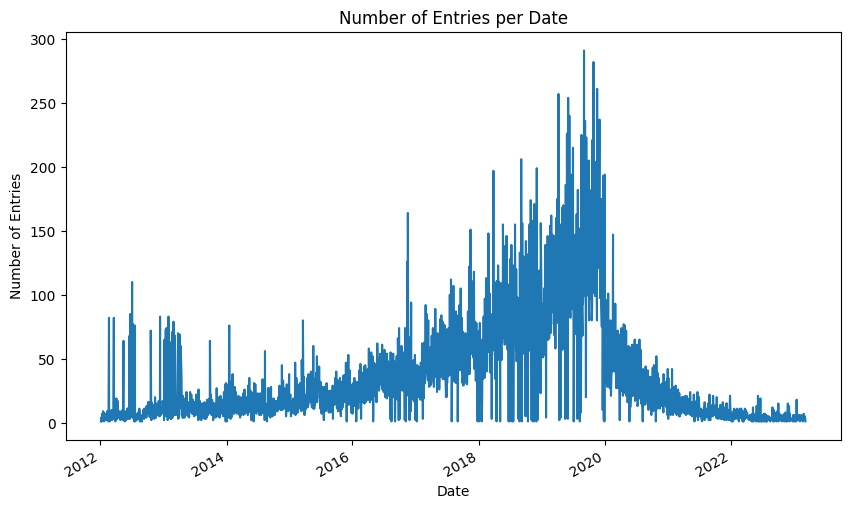

In [84]:
df_2['update_date'] = pd.to_datetime(df_2['update_date'])

# Group by the date column and count the entries
date_counts = df_2.groupby('update_date').size()

# Plotting
plt.figure(figsize=(10, 6))
date_counts.plot(kind='line', )
plt.title('Number of Entries per Date')
plt.xlabel('Date')
plt.ylabel('Number of Entries')
plt.show()

In [ ]:
date | number of papers
2012-01-01 | 150
2014-01-14 | 140
